In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from lofo import LOFOImportance # https://github.com/aerdem4/lofo-importance
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import math
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [2]:
# Import data
df_f = pd.read_csv("features.csv")
df_st = pd.read_csv("stores.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")


# check the data
df_test.head()


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### 1. data cleaning

In [3]:
#Make date column into datetime
#We cannot perform any time series based operation on the dates if they are not in the right format.
#In order to be able to work with it, we are required to convert the dates into the datetime format
df_f["Date"] = pd.to_datetime(df_f["Date"])
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# Test if it works
print(df_train[0:1].Date, df_train[-1:].Date)
print(df_test[0:1].Date, df_test[-1:].Date)
print(df_f[0:1].Date, df_f[-1:].Date)


0   2010-02-05
Name: Date, dtype: datetime64[ns] 421569   2012-10-26
Name: Date, dtype: datetime64[ns]
0   2012-11-02
Name: Date, dtype: datetime64[ns] 115063   2013-07-26
Name: Date, dtype: datetime64[ns]
0   2010-02-05
Name: Date, dtype: datetime64[ns] 8189   2013-07-26
Name: Date, dtype: datetime64[ns]


In [4]:
# Assess the total amount of columns and rows in a more consise way

print(df_f.shape)
print(df_train.shape)
print(df_test.shape)
print(df_st.shape)

(8190, 12)
(421570, 5)
(115064, 4)
(45, 3)


In [5]:
#*Next we will proceed to address the NaN values we could identify in the .head() formula above.*
#Merge data into 1 DataFrame
#We do this to get some assistance in assessing the features and the time when we proceed with the modeling.
# Merging training data
df_all_train = df_train.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
#df_all_train.head(3)

# Merging test data
df_all_test = df_test.merge(df_f, how="left", on=["Store","Date","IsHoliday"])
df_all_test.tail(3)

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
115061,45,98,2013-07-12,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN
115062,45,98,2013-07-19,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN
115063,45,98,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN


In [6]:
df_all_train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106


In [7]:
# More merging of training data
df_all_train = df_all_train.merge(df_st, how="left", on=["Store"])
df_all_train.head(3)

# More merging of test data
df_all_test = df_all_test.merge(df_st, how="left", on=["Store"])
#df_all_test.head(3)

In [8]:
df_all_train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315


In [9]:
df_all_test.head(3)

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315


In [10]:
# Check how our final df_all_train looks
print("Rows & Columns: ", df_all_train.shape, "\nAll columns if the df: ", df_all_train.columns.tolist())

# # Check how our final df_all_test looks
print("Rows & Columns: ", df_all_test.shape, "\nAll columns if the df: ", df_all_test.columns.tolist())

Rows & Columns:  (421570, 16) 
All columns if the df:  ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']
Rows & Columns:  (115064, 15) 
All columns if the df:  ['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']


In [11]:
#We got everything in the same df now to proceed to fix NaN values etc to keep everything at the same place. 
#If we need specific columns, we don't need to go through specific files, we have everything at the same place, 
#which makes it easier to keep in check.

In [12]:
#replace the t/f in isholiday
df_all_train = df_all_train.applymap(lambda x: 1 if x == True else x)
df_all_train = df_all_train.applymap(lambda x: 0 if x == False else x)

In [13]:
df_all_train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,0,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,0,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,0,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [14]:
# Check where we find NaN values
##显示出所有column的type
tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'}) 
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64


In [15]:
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))

In [16]:
#create a row for num of null values
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
null values (nb),0,0,0,0,0,0,0,270889,310322,284479,286603,270138,0,0,0,0


In [17]:
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.rename(index={0: 'null values (%)'}))

In [18]:
#null value account for what percentage of the column
tab_info

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
null values (nb),0,0,0,0,0,0,0,270889,310322,284479,286603,270138,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.257181,73.611025,67.480845,67.984676,64.079038,0.0,0.0,0.0,0.0


In [19]:
#replace Temperature, fule price, CPI and unemployment with averages. 
# This seems more reasonable than replacing them with "0"s.        
df_all_train[["Temperature"]] = df_all_train[["Temperature"]].fillna(df_all_train[["Temperature"]].mean())
df_all_train[["Fuel_Price"]] = df_all_train[["Fuel_Price"]].fillna(df_all_train[["Fuel_Price"]].mean())
df_all_train[["CPI"]] = df_all_train[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_train[["Unemployment"]] = df_all_train[["Unemployment"]].fillna(df_all_train[["Unemployment"]].mean())

In [20]:
df_all_test[["Temperature"]] = df_all_test[["Temperature"]].fillna(df_all_test[["Temperature"]].mean())
df_all_test[["Fuel_Price"]] = df_all_test[["Fuel_Price"]].fillna(df_all_test[["Fuel_Price"]].mean())
df_all_test[["CPI"]] = df_all_test[["CPI"]].fillna(df_all_train[["CPI"]].mean())
df_all_test[["Unemployment"]] = df_all_test[["Unemployment"]].fillna(df_all_test[["Unemployment"]].mean())

In [21]:
# Replace the NaN values in markdown with 0
df_all_train = df_all_train.fillna(0)
df_all_test = df_all_test.fillna(0)

In [22]:
# Check the results
df_all_train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315


In [23]:
# Check NaN values in df_all_train

tab_info = pd.DataFrame(df_all_train.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_train.isnull().sum()/df_all_train.shape[0]*100).T.
                                       rename(index={0: 'null values (%)'}))
tab_info
# Check NaN values in df_all_test

tab_info = pd.DataFrame(df_all_test.dtypes).T.rename(index={0:'column Type'}) 
tab_info = tab_info.append(pd.DataFrame(df_all_test.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_all_test.isnull().sum()/df_all_test.shape[0]*100).T.rename(index={0: 'null values (%)'}))
tab_info

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
column Type,int64,int64,datetime64[ns],bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#Create Dummy Variables for Type of Store
#We do this in order to analyse the data, as a non-numerical value will not be processed in our models.

In [25]:
df_all_train = pd.get_dummies(df_all_train, columns=["Type"])
df_all_test = pd.get_dummies(df_all_test, columns=["Type"])

In [26]:
# Checking the DFs after all of the processing
df_all_train.head(3)
#df_all_test.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,1,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,1,0,0


### 2. data explore

In [27]:
# Start with simple .describe() to get the general jist of the dataframe
df_all_train.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,0.511132,0.387824,0.101044
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,0.499877,0.487255,0.301387
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,0.000000,0.000000,0.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,0.000000,0.000000,0.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,1.000000,0.000000,0.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,1.000000,1.000000,0.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,1.000000,1.000000,1.000000


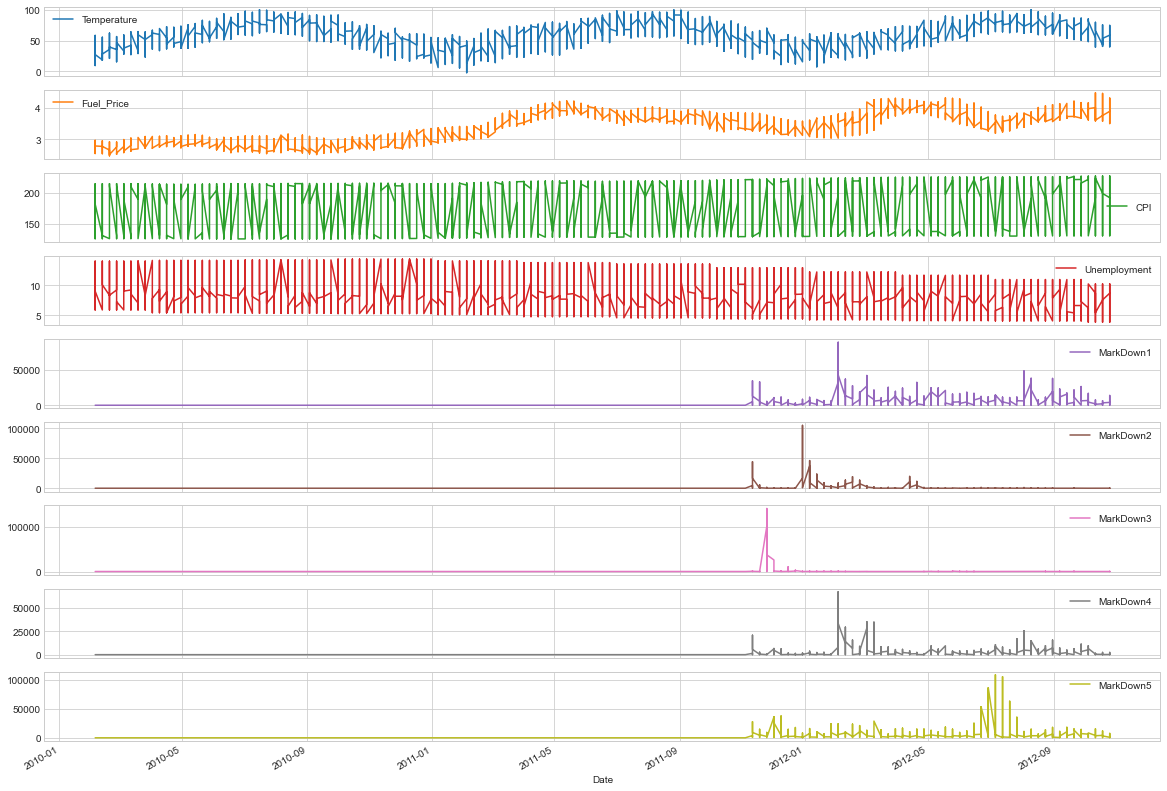

In [28]:
# Plots for the different features in the df: 
df_all_train[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].plot(x='Date', subplots=True, figsize=(20,15))

plt.show()

In [29]:
#Weekly sales plot
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = df_all_train.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()

df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

print(df_average_sales[:10])



          Date  Weekly_Sales
46  2010-12-24   80931415.60
98  2011-12-23   76998241.31
94  2011-11-25   66593605.26
42  2010-11-26   65821003.24
45  2010-12-17   61820799.85
97  2011-12-16   60085695.94
44  2010-12-10   55666770.39
96  2011-12-09   55561147.70
113 2012-04-06   53502315.87
126 2012-07-06   51253021.88


<function matplotlib.pyplot.show(close=None, block=None)>

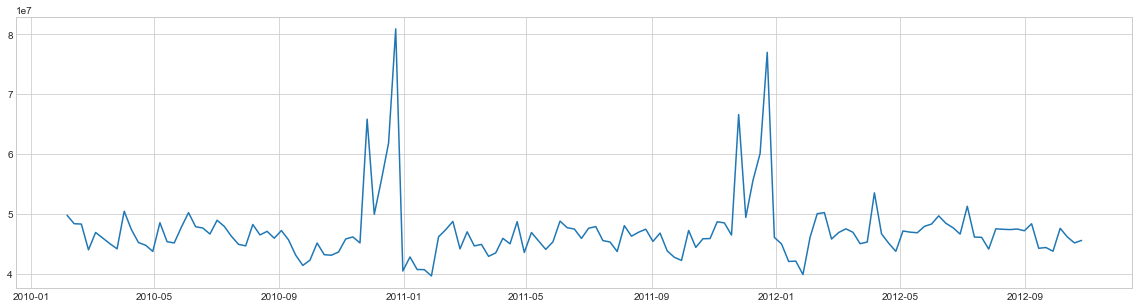

In [30]:
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.show

In [31]:
df_all_train["month"] = df_all_train['Date'].dt.month
df_all_train = df_all_train.drop(["Date"], axis=1)
df_all_train = pd.get_dummies(df_all_train, columns=["month"])#, prefix='month')
#df_all_train = df_all_train.drop('Date', 1)

df_all_test["month"] = df_all_test['Date'].dt.month
df_all_test = df_all_test.drop(["Date"], axis=1)
df_all_test = pd.get_dummies(df_all_test, columns=["month"])#, prefix='month')
#df_all_test = df_all_test.drop('Date', 1)

<AxesSubplot:>

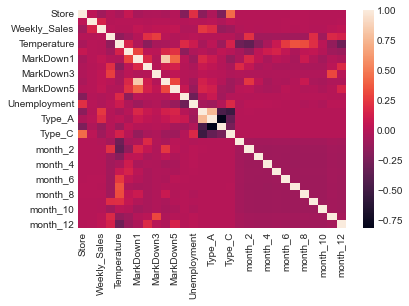

In [32]:
sns.heatmap(df_all_train.corr())

In [33]:
# Correlation between Weekly Sales and all other features
df_all_train_corr = df_all_train[df_all_train.columns[:]].corr()['Weekly_Sales'][:]
df_all_train_corr = df_all_train_corr.drop("Weekly_Sales")
df_all_train_corr

Store          -0.085195
Dept            0.148032
IsHoliday       0.012774
Temperature    -0.002312
Fuel_Price     -0.000120
MarkDown1       0.047172
MarkDown2       0.020716
MarkDown3       0.038562
MarkDown4       0.037467
MarkDown5       0.050465
CPI            -0.020921
Unemployment   -0.025864
Size            0.243828
Type_A          0.185417
Type_B         -0.131219
Type_C         -0.095388
month_1        -0.019867
month_2         0.000368
month_3        -0.007876
month_4        -0.004804
month_5        -0.002728
month_6         0.004789
month_7        -0.001731
month_8         0.001129
month_9        -0.012330
month_10       -0.010273
month_11        0.016193
month_12        0.040980
Name: Weekly_Sales, dtype: float64

<AxesSubplot:>

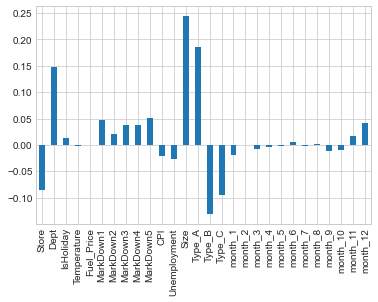

In [34]:
df_all_train_corr.plot.bar()

### 3. Create Train & Test Data.

In [35]:
# DF x & y
train_all = df_all_train # make it shorter syntax

train_X = df_all_train.drop(["Weekly_Sales", "month_8", "month_9", "month_10"], axis=1)
train_y = train_all["Weekly_Sales"]
test_X = df_all_test # making the syntax shorter --> Sub = submission

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

### 4. Benchmark

### 5. Modeling Finding the best model.

In [40]:
#Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# Print out the MAE, MSE & RMSE
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred)) #MAE
print("MSE: ", metrics.mean_squared_error(y_test, y_pred)) #MSE
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred))) #RMSE

# rSquared
score = r2_score(y_test, y_pred)
print("R^2:", score)

MAE:  4461.434718973123
MSE:  87192499.79044883
RMSE:  9337.692423208682
R^2: 0.759254883629399


In [43]:
y_pred

array([3001.665 , 2883.39  , 3051.285 , ..., 2332.9186, 2174.6655,
       2267.1637])